In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import mis_loss
from torchts.nn.model import TimeSeriesModel

# Generate data

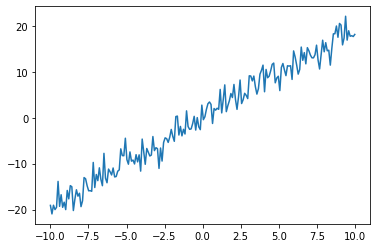

In [2]:
# generate linear time series data with some noise
n = 200
x_max = 10
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(-x_max, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

# Define model

In [3]:
class IntervalLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, interval=0.95, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=mis_loss,
            criterion_args={"interval": interval},
            **kwargs
        )
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, 2) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [4]:
input_size = 1
output_size = 1
hidden_size = 32
interval = 0.95
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = IntervalLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    interval=interval,
    optimizer_args=optimizer_args,
)

# Train model to predict confidence interval

In [5]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 4.5 K 
1 | linear | ModuleList | 66    
--------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 166.15it/s, loss=8.82, v_num=164, train_loss_step=9.680, train_loss_epoch=8.820]


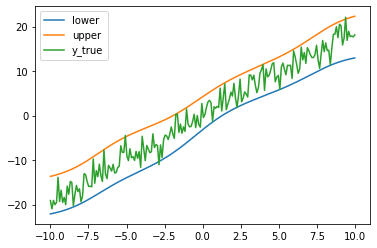

In [6]:
plt.plot(x, y_preds, label=["lower", "upper"])
plt.plot(x, y, label="y_true")
plt.legend()
plt.show()

# Add second response variable

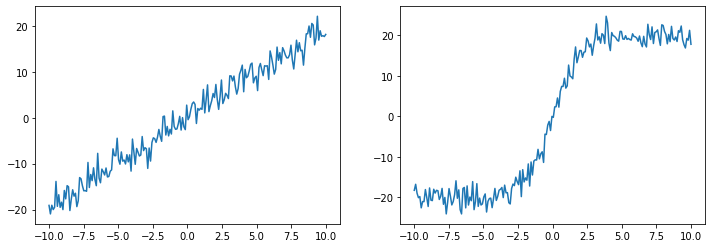

In [7]:
y_max = slope * x_max
y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
y = torch.hstack([y, y2])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y[:, 0])
plt.subplot(1, 2, 2)
plt.plot(x, y[:, 1])
plt.show()

# Train model to predict two confidence intervals

In [8]:
output_size = 2

model = IntervalLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    interval=interval,
    optimizer_args=optimizer_args,
)

In [9]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 9.0 K 
1 | linear | ModuleList | 132   
--------------------------------------
9.1 K     Trainable params
0         Non-trainable params
9.1 K     Total params
0.036     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 62.24it/s, loss=7.96, v_num=165, train_loss_step=7.450, train_loss_epoch=7.960] 


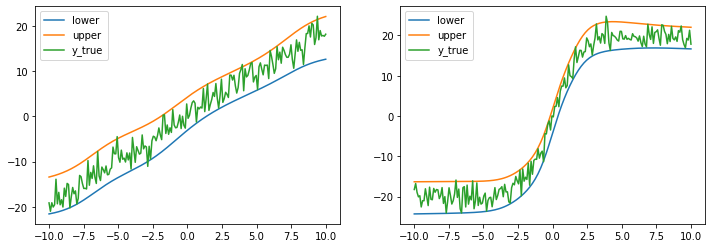

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y_preds[:, :2], label=["lower", "upper"])
plt.plot(x, y[:, 0], label="y_true")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y_preds[:, 2:], label=["lower", "upper"])
plt.plot(x, y[:, 1], label="y_true")
plt.legend()

plt.show()